In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split,KFold,cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
X = pd.read_csv("data/train.csv", )
X_test = pd.read_csv("data/test.csv",  )
X.drop(['GarageYrBlt'], axis=1, inplace=True)
X.drop(['Utilities'], axis=1, inplace=True)
X_test.drop(['GarageYrBlt'], axis=1, inplace=True)
X_test.drop(['Utilities'], axis=1, inplace=True)

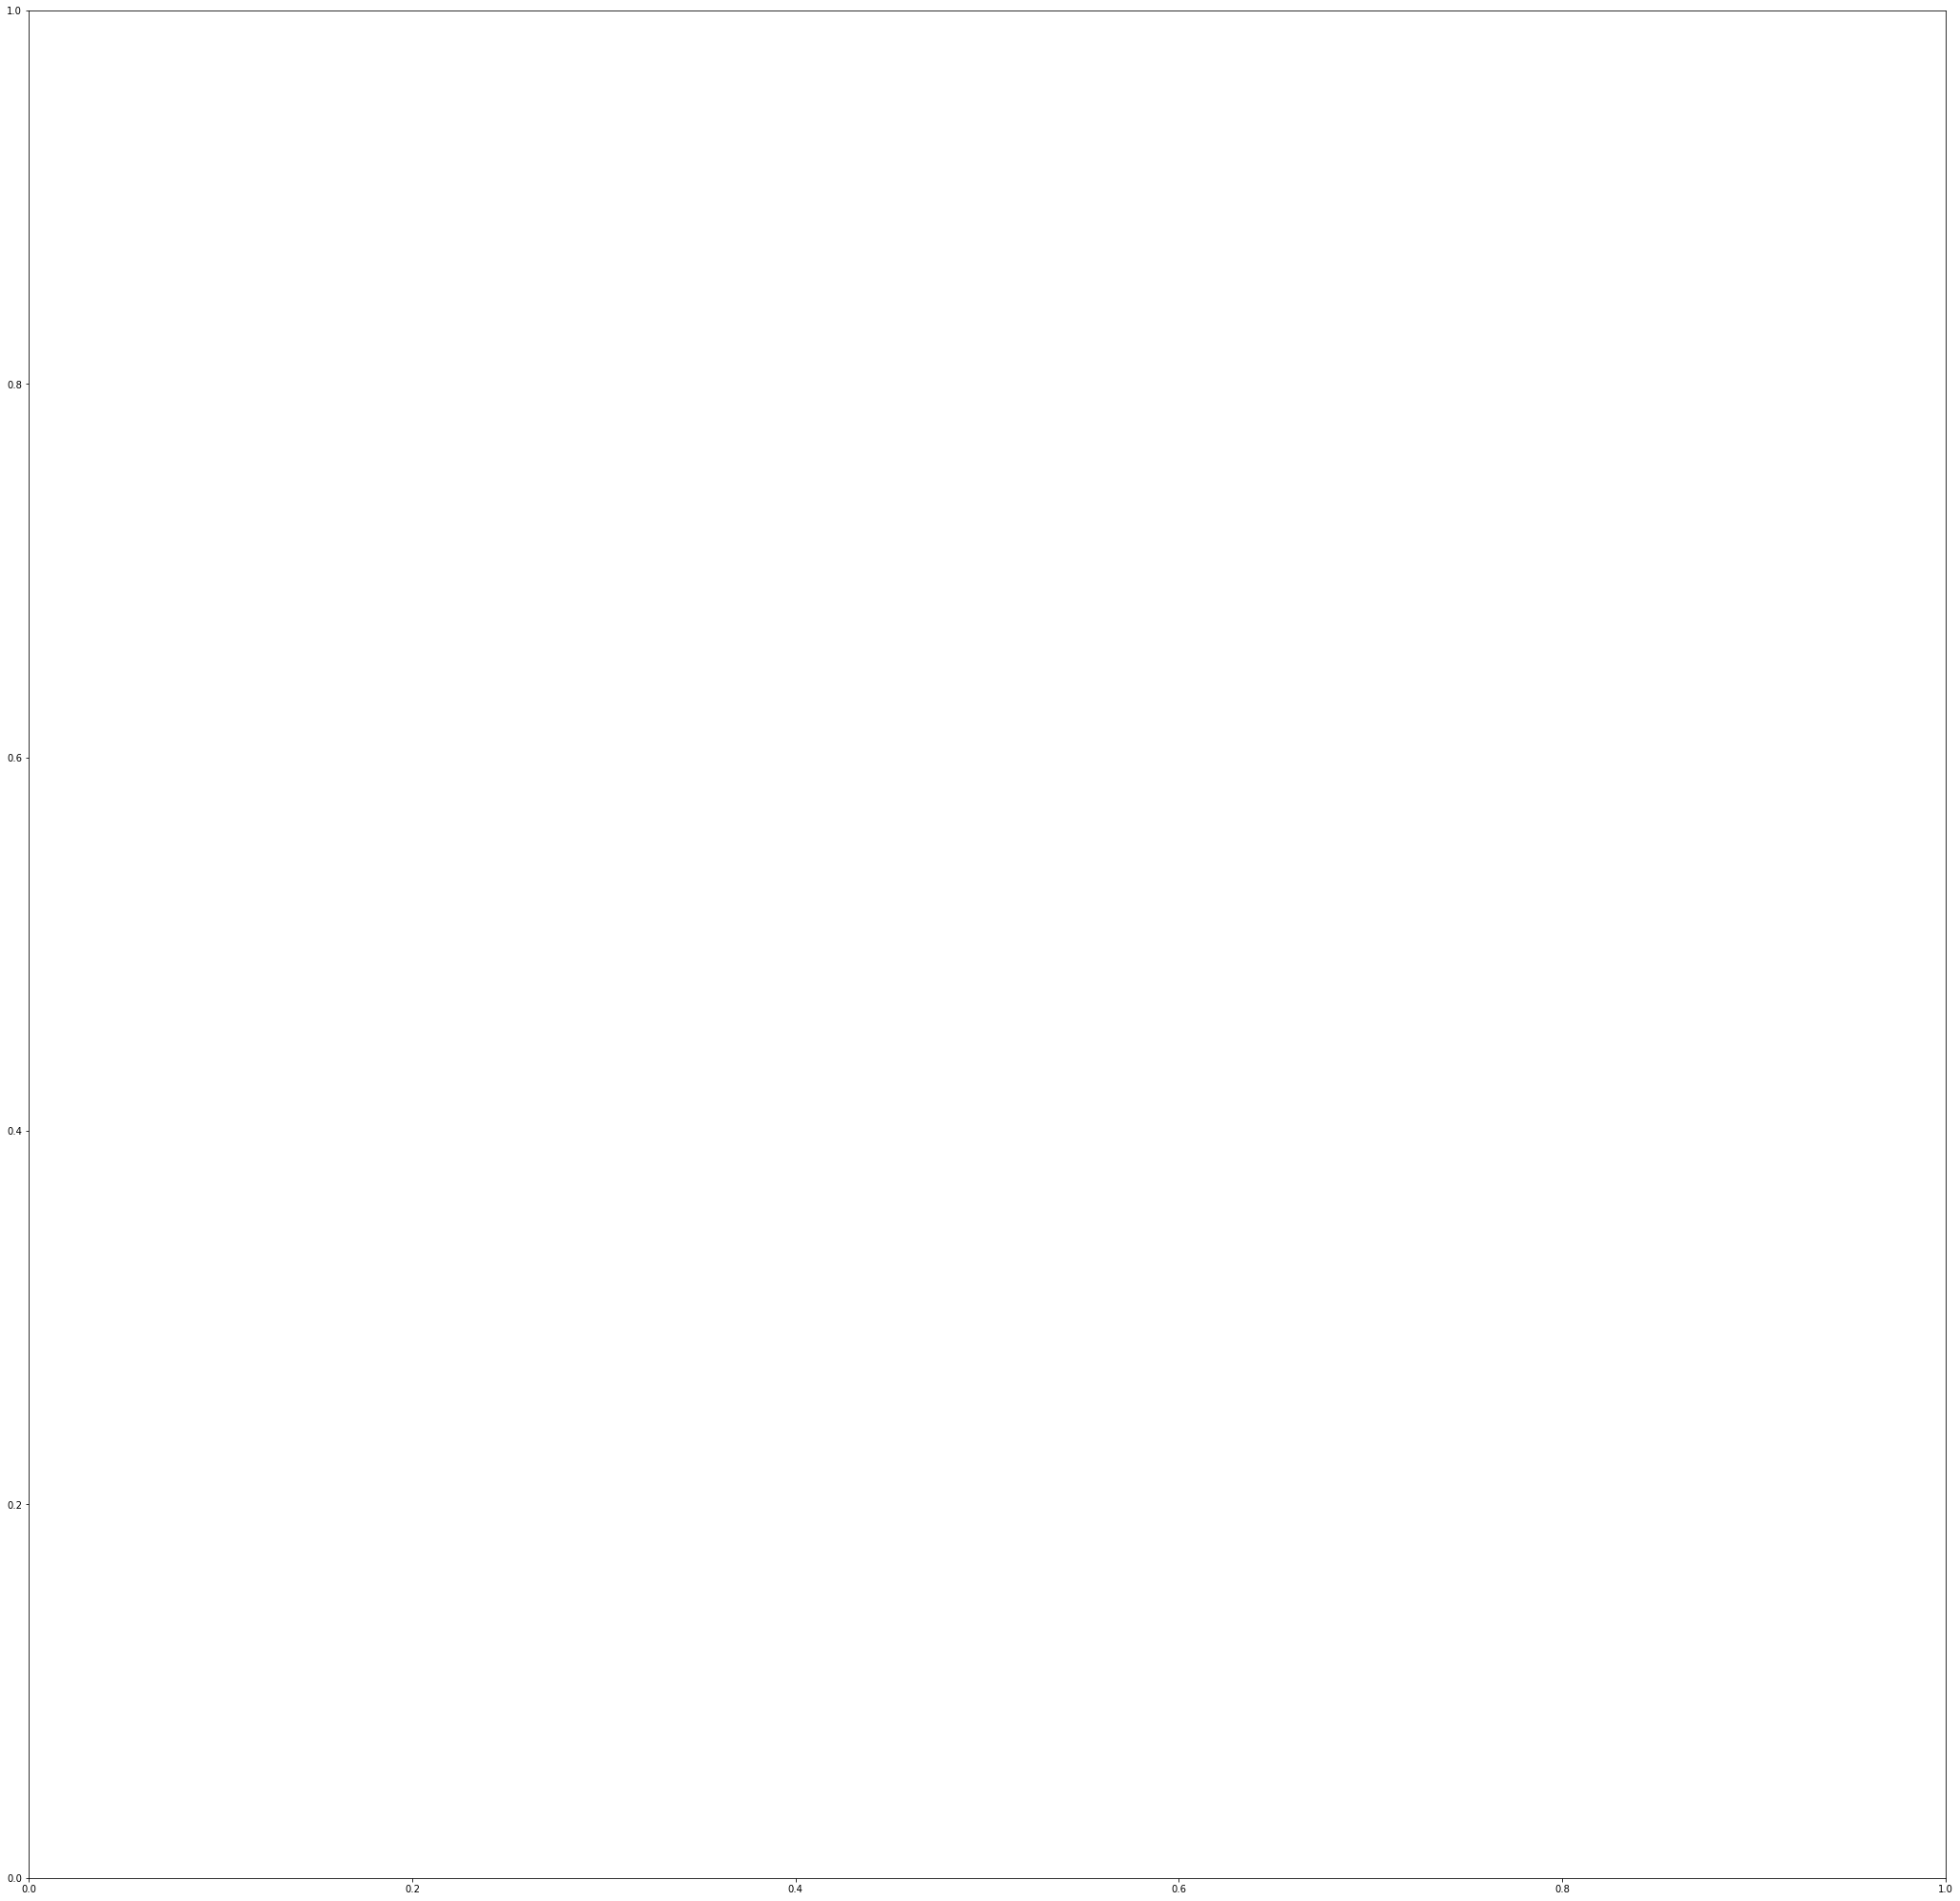

In [3]:
fig, ax = plt.subplots(figsize=(36, 36))
df_corr = X.corr()

#sns.heatmap(df_corr,annot=True)

In [4]:
class cleaner(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):


        


        X.Electrical = X.Electrical.fillna('SBrkr')
        X.BsmtFinSF1 = X.BsmtFinSF1.fillna(0)
        X.BsmtFinSF2 = X.BsmtFinSF2.fillna(0)
        X.GarageCars = X.GarageCars.fillna(0)
        X.GarageArea = X.GarageArea.fillna(0)
        X["PoolQC"] = X["PoolQC"].fillna("NA")
        X.BsmtQual[(X.BsmtFinSF1 == 0)] = X.BsmtQual[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtCond[(X.BsmtFinSF1 == 0)] = X.BsmtCond[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtCond = X.BsmtCond.fillna('TA')
        X.BsmtExposure[(X.BsmtFinSF1 == 0)] = X.BsmtExposure[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtFinType1[(X.BsmtFinSF1 == 0)] = X.BsmtFinType1[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtFinType2[(X.BsmtFinSF2 == 0)] = X.BsmtFinType2[(X.BsmtFinSF2 == 0)].fillna('NA')
        X.BsmtFinType2 = X.BsmtFinType2.fillna('Unf')
        X["MiscFeature"] = X["MiscFeature"].fillna("NA")
        X["Alley"] = X["Alley"].fillna("NA")
        X["Fence"] = X["Fence"].fillna("NA")
        X["FireplaceQu"] = X["FireplaceQu"].fillna("NA")
        X['MSSubClass'] = X['MSSubClass'].fillna("NA")
        for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
            X[col] = X[col].fillna('NA')

        #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
        X["LotFrontage"] = X.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))

        X.MasVnrArea = X.MasVnrArea.fillna(0)
        X.MasVnrType = X.MasVnrType.fillna('None')
        X.KitchenQual = X.KitchenQual.fillna('TA')
        X.Functional = X.Functional.fillna('Typ')
        X.BsmtUnfSF = X.BsmtUnfSF.fillna(0)
        X.TotalBsmtSF = X.TotalBsmtSF.fillna(0)
        X.BsmtFullBath = X.BsmtFullBath.fillna(0)
        X.BsmtHalfBath = X.BsmtHalfBath.fillna(0)

        #feature engineering for the Neighborhood
        X.loc[(X.Neighborhood == 'NridgHt') | (X.Neighborhood == 'NoRidge'), ['GoodNBH']] = 1
        X.GoodNBH = X.GoodNBH.fillna(0)
        X = X.drop(['Neighborhood'], axis=1)

        #Drop Categoricals that cannot be one hotted, and also not ordinally encoded
        X['Exterior1st'] = X['Exterior1st'].fillna(X['Exterior1st'].mode()[0])
        X['Exterior2nd'] = X['Exterior2nd'].fillna(X['Exterior2nd'].mode()[0])

        X['MSZoning'] = X['MSZoning'].fillna(X['MSZoning'].mode()[0])
        X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])

        #Convert data thats really categorical
        X['MSSubClass'] = X['MSSubClass'].apply(str) 
        X['OverallQual'] = X['OverallQual'].astype(str)  
        X['OverallCond'] = X['OverallCond'].astype(str)    
        X['YrSold'] = X['YrSold'].astype(str)
        X['MoSold'] = X['MoSold'].astype(str)
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
        
        return X
    

In [5]:
class df_Ord(BaseEstimator, TransformerMixin):
    def __init__(self,cols = [] ,cats = []):
        self.ord = None
        self.cols = cols
        self.cats = cats
      

    def fit(self, X, y=None):
        if self.cats == []:
            self.ord = OrdinalEncoder(categories="auto")
        else:
            self.ord = OrdinalEncoder(categories=[self.cats])
            
        for col in self.cols:

            self.ord.fit(X[[col]])        
        return self

    def transform(self, X):
        # X has to be a dataframe
        Xord = X.copy()
        for col in self.cols:
            Xord[col] = self.ord.transform(X[[col]])                
        Xorded = pd.DataFrame(Xord, index=X.index, columns=X.columns)
        return Xorded

class df_OH(BaseEstimator, TransformerMixin):
    def __init__(self,cols = []):
        self.OH = None
        self.cols = cols

    def fit(self, X, y=None):
        
        self.OH = OneHotEncoder(handle_unknown='ignore', sparse=False)


        self.OH.fit(X[self.cols])        
        return self

    def transform(self, X):

        XOHedcols = pd.DataFrame(self.OH.transform(X[self.cols]))  
        XOHedcols.index = X.index
        numX = X.drop(self.cols, axis=1)
        XOHed = pd.concat([numX,XOHedcols], axis=1)
        return XOHed    
    
    



 mu = 180921.20 and sigma = 79415.29



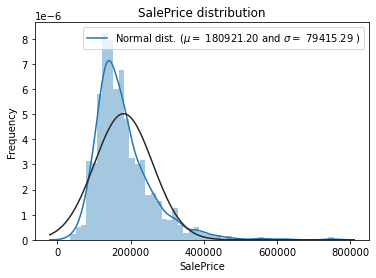

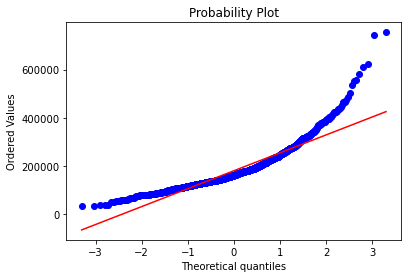


 mu = 12.02 and sigma = 0.40



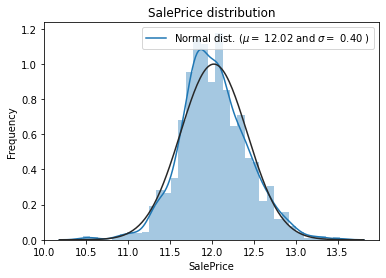

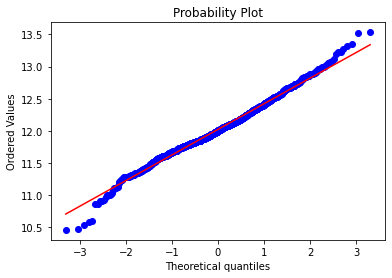

In [6]:
    



#correcting right Skew of data

sns.distplot(X['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X['SalePrice'], plot=plt)
plt.show()


#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
X["SalePrice"] = np.log1p(X["SalePrice"])

#Check the new distribution 
sns.distplot(X['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X['SalePrice'], plot=plt)
plt.show()

#drop outlier
X = X.drop(X[(X['GrLivArea']>4000) & (X['SalePrice']<300000)].index)


X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)    
    


In [7]:
#Except model to param tune
pipeXGB = Pipeline([
                         ('clean', cleaner())
                         ,('ord',df_Ord(cols=['ExterQual','ExterCond','HeatingQC','KitchenQual'], cats=['Po','Fa','TA','Gd','Ex']))
                         ,('ord2',df_Ord(cols=['BsmtQual','BsmtCond','FireplaceQu','GarageQual','GarageCond'], cats=['NA','Po','Fa','TA','Gd','Ex']))
                         ,('ord3',df_Ord(cols=['PoolQC'], cats=['NA','Fa','TA','Gd','Ex']))
                         ,('ord4',df_Ord(cols=['MiscFeature'], cats=['NA','Othr','Shed','Gar2','Elev','TenC']))
                         ,('ord5',df_Ord(cols=['Fence'], cats=['NA','MnWw','GdWo','MnPrv','GdPrv']))
                         ,('ord6',df_Ord(cols=['Alley'], cats=['NA','Grvl','Pave']))
                         ,('ord7',df_Ord(cols=['BsmtExposure'], cats=['NA','No','Mn','Av','Gd']))
                         ,('ord8',df_Ord(cols=['BsmtFinType1','BsmtFinType2'], cats=['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'])) 
                         ,('ord9',df_Ord(cols=['CentralAir'], cats=['N','Y'])) 
                         ,('ord10',df_Ord(cols=['Functional'], cats=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']))
                         ,('ord11',df_Ord(cols=['MSSubClass'], cats=['20','30','40','45','50','60','70','75','80','85','90','120','150','160','180','190']))
                         ,('ord12',df_Ord(cols=['YrSold']))
                         ,('ord13',df_Ord(cols=['MoSold']))
                         ,('ord14',df_Ord(cols=['OverallCond']))
                         ,('ord15',df_Ord(cols=['OverallQual']))
                         ,('ord16',df_Ord(cols=['GarageType']))
                         ,('ord17',df_Ord(cols=['GarageFinish']))
                         ,('ord18',df_Ord(cols=['Exterior1st']))
                         ,('ord19',df_Ord(cols=['Exterior2nd']))                          
                         ,('oh1',df_OH(cols=['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'PavedDrive', 'SaleType', 'SaleCondition']))
                         ])
    
# Transform the data
X_train = pipeXGB.fit_transform(X_train)
X_valid = pipeXGB.transform(X_valid)
X_test = pipeXGB.transform(X_test)



In [95]:

import lightgbm as lgb
from bayes_opt import BayesianOptimization
def search_best_param(X,y,cat_features):
    
    trainXY = lgb.Dataset(data=X, label=y,categorical_feature = cat_features,free_raw_data=False)
    # define the lightGBM cross validation
    def lightGBM_CV(max_depth, num_leaves, n_estimators, learning_rate, subsample, colsample_bytree, 
                lambda_l1, lambda_l2, min_child_weight):
    
        params = {'boosting_type': 'gbdt', 'objective': 'regression', 'metric':'rmse', 'verbose': -1,
                  'early_stopping_round':500}
        
        params['max_depth'] = int(round(max_depth))
        params["num_leaves"] = int(round(num_leaves))
        params["n_estimators"] = int(round(n_estimators))
        params['learning_rate'] = learning_rate
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_child_weight'] = min_child_weight
    
        score = lgb.cv(params, trainXY, nfold=5, seed=1, stratified=False, verbose_eval =False, metrics=['rmse'])

        return -np.min(score['rmse-mean']) # return negative rmse to minimize rmse 

    # use bayesian optimization to search for the best hyper-parameter combination
    lightGBM_Bo = BayesianOptimization(lightGBM_CV, 
                                       {
                                          'max_depth': (3, 30),
                                          'num_leaves': (8, 64),
                                          'n_estimators': (100, 1000),
                                          'learning_rate': (0.01, 0.3),
                                          'subsample': (0.1, 1),
                                          'colsample_bytree' :(0.1, 1),
                                          'lambda_l1': (0, 10),
                                          'lambda_l2': (0, 10),
                                          'min_child_weight': (2, 100) 
                                      },
                                       random_state = 1,
                                       verbose = 1
                                      )
    np.random.seed(1)
    
    lightGBM_Bo.maximize(init_points=5, n_iter=15) 
    
    params_set = lightGBM_Bo.max['params']
    
    # get the params of the maximum target     
    max_target = -np.inf
    for i in lightGBM_Bo.res: # loop thru all the residuals 
        if i['target'] > max_target:
            params_set = i['params']
            max_target = i['target']
    
    params_set.update({'verbose': -1})
    params_set.update({'metric': 'rmse'})
    params_set.update({'boosting_type': 'gbdt'})
    params_set.update({'objective': 'regression'})
    
    params_set['max_depth'] = int(round(params_set['max_depth']))
    params_set['num_leaves'] = int(round(params_set['num_leaves']))
    params_set['n_estimators'] = int(round(params_set['n_estimators']))
    params_set['seed'] = 1 #set seed
    
    return params_set
cat_features = X_train.select_dtypes(['object']).columns.to_list()
best_params = search_best_param(X_train,y_train,cat_features)


|   iter    |  target   | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  2        | -0.1461   |  0.5849   |  4.192    |  6.852    |  0.06929  |  26.71    |  4.684    |  703.4    |  31.37    |  0.6028   |
|  3        | -0.1413   |  0.2263   |  1.981    |  8.007    |  0.2908   |  11.46    |  69.85    |  888.8    |  58.1     |  0.1765   |
|  6        | -0.1357   |  0.645    |  2.0      |  6.752    |  0.07269  |  25.65    |  4.622    |  993.0    |  11.1     |  0.3054   |
|  13       | -0.1336   |  0.6494   |  0.4511   |  4.362    |  0.1465   |  6.397    |  32.9     |  317.5    |  55.05    |  0.8666   |


In [96]:
for key, value in best_params.items():
    print(key, ' : ', value)

colsample_bytree  :  0.6493653956575565
lambda_l1  :  0.4511253212037203
lambda_l2  :  4.361914457390064
learning_rate  :  0.1465427652886336
max_depth  :  6
min_child_weight  :  32.89964785030046
n_estimators  :  318
num_leaves  :  55
subsample  :  0.8666230688297513
verbose  :  -1
metric  :  rmse
boosting_type  :  gbdt
objective  :  regression
seed  :  1


In [97]:
train_data=lgb.Dataset(X_train,label=y_train, categorical_feature = cat_features,free_raw_data=False)
valid_data=lgb.Dataset(X_valid,label=y_valid, categorical_feature = cat_features,free_raw_data=False)

lgbm_best = lgb.train(best_params,
                 train_data,
                 num_boost_round = 1000,
                 valid_sets = valid_data,
                 early_stopping_rounds = 500,
                 verbose_eval = 100
                 )

Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 0.111363
[200]	valid_0's rmse: 0.112942
[300]	valid_0's rmse: 0.112776
Did not meet early stopping. Best iteration is:
[86]	valid_0's rmse: 0.111129


In [98]:

test_data=lgb.Dataset(X_test, categorical_feature = cat_features,free_raw_data=False)


In [99]:
df = pd.DataFrame(columns=['Id','SalePrice'])
df['Id'] = X_test.Id
df['SalePrice'] = np.expm1(lgbm_best.predict(X_test))
df[['Id','SalePrice']].to_csv('submission1.csv', index=False)